<a href="https://colab.research.google.com/github/atree-unb/testrepo/blob/master/Freshness_Detection_Apple.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fruit Freshness Detection for Apples

This notebook demonstrates training a deep learning model to classify apple freshness into three categories: Fresh, and Rotten.

#Step 1: Importing Libraries and Dataset

In [1]:

import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
import cv2
import os


Mount Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [3]:
path = '/content/drive/MyDrive/ColabNotebooks/TME6015/apples-fresh-and-rotten-dataset'

In [4]:
import shutil

destination_folder = '/content/drive/MyDrive/ColabNotebooks/TME6015/apples-fresh-and-rotten-dataset'  # Replace with your desired location in Google Drive

try:
    shutil.copytree(path, destination_folder)
    print(f"Dataset successfully copied to: {destination_folder}")
except FileExistsError:
    print(f"Folder '{destination_folder}' already exists. Skipping copy operation.")
except Exception as e:
    print(f"An error occurred during copy operation: {e}")


Folder '/content/drive/MyDrive/ColabNotebooks/TME6015/apples-fresh-and-rotten-dataset' already exists. Skipping copy operation.


## Step 2: Data Preparation

- Load images of apples.
- Resize to 224x224 pixels.
- Normalize pixel values.

In [6]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

def load_dataset(dataset_path):
    """
    Loads images and their labels from a dataset structure:
    apples-fresh-and-rotten-dataset/
        train/
            fresh/
            rotten/
        test/
            fresh/
            rotten/

    Args:
        dataset_path (str): Path to the dataset folder.

    Returns:
        tuple: Images and labels for both training and testing sets.
    """
    categories = ['fresh', 'rotten']
    data = {'train': [], 'test': []}
    labels = {'train': [], 'test': []}

    for split in ['train', 'test']:
        split_path = os.path.join(dataset_path, split)
        if not os.path.exists(split_path):
            raise FileNotFoundError(f"'{split_path}' does not exist. Check your dataset structure.")

        for label, category in enumerate(categories):
            category_path = os.path.join(split_path, category)
            if not os.path.exists(category_path):
                print(f"Skipping missing category folder: {category_path}")
                continue

            for img_name in os.listdir(category_path):
                img_path = os.path.join(category_path, img_name)
                try:
                    img = cv2.imread(img_path)
                    if img is None:
                        print(f"Warning: Unable to load image '{img_path}'. Skipping.")
                        continue
                    img = cv2.resize(img, (224, 224))  # Resize for CNN input
                    data[split].append(img)
                    labels[split].append(label)
                except Exception as e:
                    print(f"Error processing image {img_path}: {e}")
                    continue

    # Convert to NumPy arrays
    train_images = np.array(data['train'])
    train_labels = np.array(labels['train'])
    test_images = np.array(data['test'])
    test_labels = np.array(labels['test'])

    return train_images, train_labels, test_images, test_labels

# Define dataset directory
dataset_path = '/content/drive/MyDrive/ColabNotebooks/TME6015/apples-fresh-and-rotten-dataset'

# Load dataset
train_images, train_labels, test_images, test_labels = load_dataset(dataset_path)

# Normalize images to [0, 1]
train_images = train_images / 255.0
test_images = test_images / 255.0

# Split train set further into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

# Output shapes for confirmation
print(f"Training set: {x_train.shape}, {y_train.shape}")
print(f"Validation set: {x_val.shape}, {y_val.shape}")
print(f"Test set: {test_images.shape}, {test_labels.shape}")


Training set: (3228, 224, 224, 3), (3228,)
Validation set: (807, 224, 224, 3), (807,)
Test set: (996, 224, 224, 3), (996,)


In [7]:
train_images.shape


(4035, 224, 224, 3)

## Step 3: Model Definition

- Use MobileNetV2 as a base pre-trained model.
- Add a classification layer with three outputs.

In [8]:

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy', metrics=['accuracy'])


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


## Step 4: Data Augmentation

In [9]:

train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
val_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(x_train, y_train, batch_size=32)
val_generator = val_datagen.flow(x_val, y_val, batch_size=32)


## Step 5: Training the Model

In [10]:

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    steps_per_epoch=len(x_train) // 32,
    validation_steps=len(x_val) // 32
)


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


100/100 ━━━━━━━━━━━━━━━━━━━━ 57s 407ms/step - accuracy: 0.8329 - loss: 0.3795 - val_accuracy: 0.9575 - val_loss: 0.1208
Epoch 2/10
  1/100 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8750 - loss: 0.2562

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.8750 - loss: 0.2562 - val_accuracy: 1.0000 - val_loss: 0.0816
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 32s 296ms/step - accuracy: 0.9623 - loss: 0.1176 - val_accuracy: 0.9700 - val_loss: 0.0804
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 208us/step - accuracy: 0.9688 - loss: 0.0806 - val_accuracy: 0.8571 - val_loss: 0.2530
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 32s 298ms/step - accuracy: 0.9715 - loss: 0.0771 - val_accuracy: 0.9762 - val_loss: 0.0668
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 209us/step - accuracy: 1.0000 - loss: 0.0696 - val_accuracy: 1.0000 - val_loss: 0.0099
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 32s 298ms/step - accuracy: 0.9805 - loss: 0.0604 - val_accuracy: 0.9775 - val_loss: 0.0544
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 209us/step - accuracy: 0.9688 - loss: 0.0999 - val_accuracy: 1.0000 - val_loss: 0.0680
Epoch 9/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 32s 297ms/step - accuracy: 0.9879 - loss: 0.0467 - val_accu

In [14]:
model.save('fruit_freshness_apple_model.h5')

## Step 6: Evaluating the Model

In [15]:
x_test, x_rem, y_test, y_rem = train_test_split(test_images, test_labels, test_size=0.2, random_state=42)

# x_test, y_test will contain the testing data
# x_rem, y_rem will contain the remaining data (which can be used for training if needed)

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9866 - loss: 0.0423
Test Accuracy: 98.74%


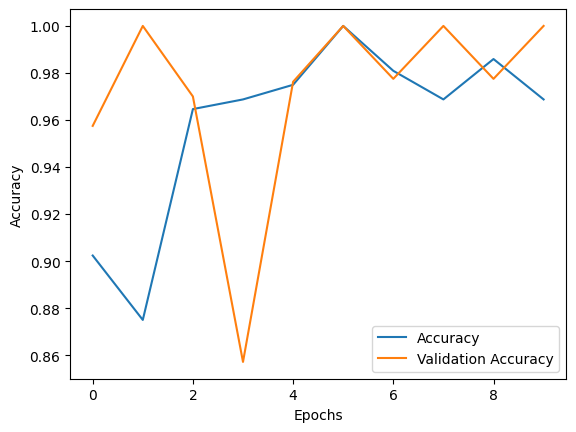

In [16]:

loss, accuracy = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step
Classification Report:
               precision    recall  f1-score   support

 Fresh Apples       1.00      0.97      0.98       312
Rotten Apples       0.98      1.00      0.99       484

     accuracy                           0.99       796
    macro avg       0.99      0.98      0.99       796
 weighted avg       0.99      0.99      0.99       796



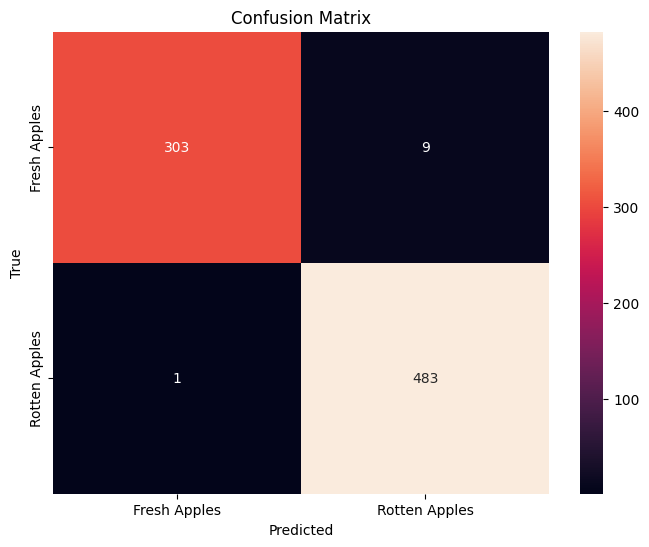

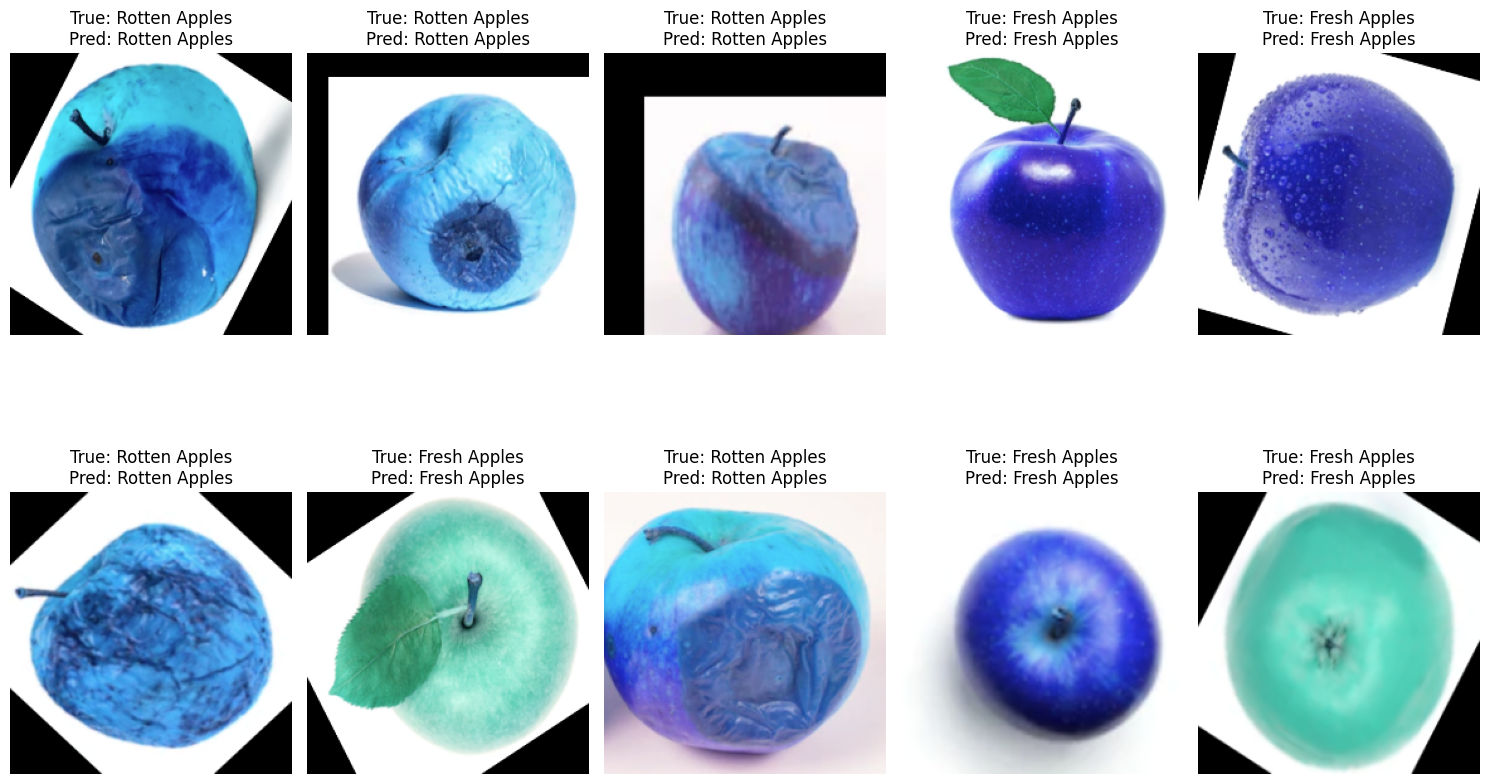

In [17]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load your trained model
model_path = "fruit_freshness_apple_model.h5"  # Update with your actual model path
model = tf.keras.models.load_model(model_path)

# Function for making predictions on test images
def test_model(model, x_test, y_test, class_names):
    """
    Evaluate the model on test data and display metrics and visualizations.

    Args:
        model: Trained TensorFlow/Keras model.
        x_test (np.array): Test images.
        y_test (np.array): True labels for test images.
        class_names (list): List of class names corresponding to labels.
    """
    # Predict on the test dataset
    y_pred_probs = model.predict(x_test)
    y_pred = np.argmax(y_pred_probs, axis=1)

    # Classification report
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=class_names))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    # Example visualizations
    num_samples = 10
    sample_indices = np.random.choice(range(len(x_test)), num_samples, replace=False)
    plt.figure(figsize=(15, 10))
    for i, idx in enumerate(sample_indices):
        plt.subplot(2, 5, i + 1)
        plt.imshow(x_test[idx])
        plt.title(f"True: {class_names[y_test[idx]]}\nPred: {class_names[y_pred[idx]]}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Define your test data and class names
# Assuming x_test and y_test are already loaded and processed
class_names = ["Fresh Apples", "Rotten Apples"]

# Test the model
test_model(model, x_test, y_test, class_names)


# Step 7: Downstream Application



This downstream applicaiton is a flask app where you can upload an image of an apple and the model would tell you if it is fresh or is rotten.

In [18]:
# Install required libraries
!pip install flask tensorflow pillow pyngrok

# Import necessary libraries
import tensorflow as tf
from flask import Flask, request, jsonify, render_template_string
from pyngrok import ngrok
from PIL import Image
import numpy as np
import io
import os

# Load the pre-trained model (ensure the model file is uploaded)
MODEL_PATH = 'fruit_freshness_apple_model.h5'
if not os.path.exists(MODEL_PATH):
    raise FileNotFoundError("Model file not found. Please upload 'apple_freshness_model.h5'.")

model = tf.keras.models.load_model(MODEL_PATH)

# Preprocess function
def preprocess_image(image):
    img = Image.open(io.BytesIO(image)).convert('RGB')
    img = img.resize((224, 224))  # Resize to match MobileNetV2 input size
    img_array = np.array(img) / 255.0  # Normalize pixel values
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array

# Flask App with GUI
app = Flask(__name__)

# HTML template for the GUI
html_template = """
<!DOCTYPE html>
<html>
<head>
    <title>Apple Freshness Detector</title>
</head>
<body>
    <h1>Apple Freshness Detector</h1>
    <p>Upload an image of an apple to check if it's fresh or rotten.</p>
    <form action="/predict" method="post" enctype="multipart/form-data">
        <input type="file" name="file" accept="image/*" required>
        <button type="submit">Upload and Predict</button>
    </form>
    {% if result %}
        <h2>Result: {{ result['class'] }}</h2>
        <p>Confidence: {{ result['confidence'] }}%</p>
    {% endif %}
</body>
</html>
"""

@app.route("/", methods=["GET"])
def home():
    return render_template_string(html_template)

@app.route("/predict", methods=["POST"])
def predict():
    if "file" not in request.files:
        return render_template_string(html_template, result={"error": "No file provided"})

    file = request.files["file"]
    if not file:
        return render_template_string(html_template, result={"error": "Invalid file"})

    try:
        # Preprocess the uploaded image
        image_data = file.read()
        preprocessed_image = preprocess_image(image_data)

        # Get predictions
        predictions = model.predict(preprocessed_image)
        class_names = ["fresh", "rotten"]
        predicted_class = class_names[np.argmax(predictions)]
        confidence = float(np.max(predictions) * 100)

        # Render the result
        result = {"class": predicted_class, "confidence": f"{confidence:.2f}"}
        return render_template_string(html_template, result=result)
    except Exception as e:
        return render_template_string(html_template, result={"error": str(e)})

!ngrok config remove-authtoken

# Update the authtoken with the correct value
!ngrok authtoken 2pOubVqsx2VDCx5VWiNNwlaQqKd_76dZtJYinZWJQKq5WBDX8

# Start ngrok and Flask server
public_url = ngrok.connect(5000)
print(f"Public URL: {public_url}")

app.run(port=5000)


NAME:
  config - update or migrate ngrok's configuration file

USAGE:
  ngrok config [flags]

DESCRIPTION: 
  The config command gives a quick way to create or update ngrok's configuration
  file. Use 'add-authtoken' or 'add-api-key' to set the corresponding properties.

  Use 'check' to test a configuration file for validity. If you have an old
  configuration file, you can also use 'upgrade' to automatically migrate to the
  latest version.

COMMANDS:
  add-api-key                    save api key to configuration file
  add-authtoken                  save authtoken to configuration file
  add-connect-url                adds the connect URL (connect_url) to configuration file for custom agent ingress
  add-server-addr                alias of add-connect-url
  check                          check configuration file
  edit                           edit configuration file
  upgrade                        auto-upgrade configuration file

OPTIONS:
      --config strings   path to config f

INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug:127.0.0.1 - - [26/Nov/2024 20:06:19] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [26/Nov/2024 20:06:20] "GET /favicon.ico HTTP/1.1" 404 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


INFO:werkzeug:127.0.0.1 - - [26/Nov/2024 20:06:29] "POST /predict HTTP/1.1" 200 -
